## Overview and Abstract
-Group: Group A
Kaggle team name: Diamond Hands 🙌💎💎🙌

Team members:
Adriano Arenas - 202063415
Colin Hanley - 202073499
Nicolas Kirsch – 202077864


The task for this project was to predict each instance of a document being loaded as relevant or not to the customer. 

We created a shallow machine learning model, 2 dense neural networks and an alternative architecture network suited for this task. The shallow model and standard architecture networks peformed poorly, giving F1 validation scores of between .1 and .2. The alternative architecture was able to process customer ID’s and tender categories using embedding layers which lead to F1 validation scores of circa .45 and the highest kaggle performance score.

# Method


## Data processing

The following attributes were removed
  *   New-Sub -  little face value relevance based on initial EDA
  *   Premium Pack - little face value relevance based on initial EDA
  *   Session Id - values are nearly all unique, therfore was removed
  *  Query Id - values are nearly all unique, therfore was removed
  *   Day - Found not to improve model, removed to reduce dimensionality
  *   Hour - Found not to improve model, removed to reduce dimensionality

Users were tokenised using the keras tokenizer function. This was used so that models could distinguish the same user from other users. 
Cpvs columns were also tokenised using the keras tokenizer function and then padded. This transformation essentially treats the cpvs codes as text in which relationships between the values can be formed.
Cpvs were dropped for non embedding models as the cardinality with one hot encoding was far too large for only marginal gain. To keep dimensionality to a minimum, the number of categories for Dwell, Month, and Nature was reduced by respectively introducing the class 'Other' for categories found non significant in differerentiating between relevant and irrelevant.


## Models


###Baseline Model - Support Vector Machine Classification

Support vector machine classification was the chosen baseline model. Support vectors are known to be great at handling high dimensional data with low to medium volume data sets. (Géron, A., 2019)
This however, also means that they are not well suited for high volume data sets and it proved impossible to fit the data with augmented data.

### Dense 3-layer neural network

Since the 3-layer neural network was only allowed to have 3 layers it could only consist of the following of the following:
1.	Input Layer – Where the raw data is taken in. 
2.	Denser Layer – This is where the input layer's data are fed forward and transformed into neuron activations. There were 300 selu activation neurons within this dense layer. The layer was batch normalized and initialized using Lecun initialisation to mitigate the unstable gradient problem 
3.	Output Layer – This is where the dense layer activations from the dense layer are taken and used in a single sigmoid neuron to predict the binary classification required. 

The activation function is a sigmoid neuron which is acts nearly identical to SoftMax in binary classification.
Adam, Lr = 0.0001. loss = Binary Cross entropyclass. Weight = {0:1, 1:16}. Epochs = 1000. Batch size = 1000.



### Dense Neural Network - DenseMultiLayer

An additional model restricted to only using sequential feed forward dense layers was constructed with the following elements: 
1.	Traditional Input Layer 
2.	Dense Layers – Input layer is fed into 5 dense layers, first with 100 nuerons and the rest 50, all are batch normalized, l2 regularized, and kernel initialized with he_normal in accordance to having a Relu Activation function.  Batch normalization and initialization are even more important here to mitigate the unstable gradient problem 
3.	Output Layer – Output layer is identical to the baseline 3 layer model


Adam, Lr = 0.0001 with schedule. loss = Binary Cross entropyclass. Weight = {0:1, 1:16}. Epochs = 100. Batch size = 1000. 


###Alternative Architecture 

The alternative architecture was inspired by Res Net CNNs which use skip layers to help reduce the unstable gradient problem (Kaiming He et al, 2016). 
User and CPVS columns were used in addition to the standard numeric data. Embedding layers were used to manage the high cardinality that these attributes would generate if one hot encoded.  Inspired by NLP, the CPVS attribute was analysed like text, to try and find relationships between different CPVS codes on the same tender.

  1.   Input Layers
    *   All the data inputs inserted into their respesctive embedding or non embedding layers.

  2.   Dense Layers
    *   User Data, Cpvs Data and rest data are concatonated into 1.
    *  This concatonation was then passed sequentially with 10 dense layers. The output of every additional 3rd layer was concatenated with the output of the layers of 3 activations before as per resent architecture theory. (Géron, A., 2019)
  3. Output Layer – Output layer is identical to the baseline model.

All dense and output layers are batch normalized and kernel initialized. In addition to this, all layers have l2 regularization and dropout to reduce overfitting. Each dense layer contained 6 neurons. Learning rate smoothing was implemented again. Smaller epoch counts of 25 were implemented as it converged quickly.


---
Run Feature Processing before runnning the models below

---

##Packages Needed to run the models & Models


In [ ]:
#Importing relevant Libraries and functions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ast
from collections import Counter

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from collections import Counter
from sklearn.feature_extraction import FeatureHasher
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras 

from tensorflow.math import confusion_matrix
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Embedding, Dense, Dropout
from keras.utils.vis_utils import plot_model

In [ ]:
#Defining learning rate smoothing function
def exponential_decay(lr0,s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0 = 0.001, s=20)

lr_schedular = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

###SVC Baseline Model

In [ ]:
#Grid Search Used to find optimal hyper paramaters.

SVCmodel = SVC()
model = SVCmodel
space = {
     'kernel': [ 'rbf', 'sigmoid'],
     'degree': [1,2,3],
     'gamma': ['scale', 'auto'],
     'C': [0.5,0.75,1,1.25,1.5]
}

search = GridSearchCV(estimator = SVC(), param_grid = space, scoring = 'f1_macro', cv =skf , n_jobs = -1, verbose = True)
result = search.fit(X_scaled, y)
print('Best score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
#Defining the SVC model and Fitting it on training Data
SVCmodel = SVC(C =1.25, degree = 1, gamma ='auto', kernel = 'sigmoid', class_weight = 'balanced')
SVCmodel.fit(X_train_scaled, y_train)

#Finding Validation Score on training data.
from sklearn.metrics import f1_score
y_pred = SVCmodel.predict(X_val_scaled)
print(f1_score(y_pred, y_val))

0.10928652321630804


In [ ]:
#Cell is used to predict on test data and save output.
SVCpred = SVCmodel.predict(test_data)
SVCpred = pd.DataFrame(SVCpred)
SVCpred.columns = ['psrel']
SVCpred = pd.concat([test_w_id['Id'], SVCpred], axis=1) #concatenate ID of each song with its prediction
SVCpred = SVCpred.astype(int)
SVCpred
#Export file to csv ready to upload
SVCpred.to_csv("SVC_predictions.csv", index=False)

In [ ]:
#Defining the SVC model and Fitting it on augmented training Data
AugSVC = SVC(C =1.25, degree = 1, gamma ='auto', kernel = 'rbf', class_weight = 'balanced')
#AugSVC.fit(X_aug_train_scaled, y_aug_train) Commented out as it is not suited for augmented data #Commenting this out as SVC doesnt run on the large augmented data set.

#Finding Validation Score on augmented training data.
from sklearn.metrics import f1_score
y_aug_pred = SVC.predict(X_aug_val_scaled)
f1_score(y_aug_pred, y_aug_val)

In [ ]:
#Cell is used to predict on augmented test data and save output.
augSVCpred = AugSVC.predict(test_data)
augSVCpred = pd.DataFrame(augSVCpred)
augSVCpred.columns = ['psrel']
augSVCpred = pd.concat([test_data['Id'], augSVCpred], axis=1) #concatenate ID of each song with its prediction
augSVCpred = SVCpred.astype(int)

#Export file to csv ready to upload
augSVCpred.to_csv("aug_SVC_predictions", index=False)


### Dense3Layer - Model 2 

In [ ]:
class Dense3Layer(tf.keras.Model):
    
    def __init__(self, units = 300, activation ='selu', out_activation = 'sigmoid', initializer = 'LecunNormal', **kwargs):
        super(Dense3Layer, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units, activation= activation, kernel_initializer = initializer)
        self.main_out = tf.keras.layers.Dense(units = 1, activation= out_activation,  kernel_initializer = 'GlorotNormal')
        
    def call(self, inputs):
        keras.layers.BatchNormalization()
        dense1 = self.dense1(inputs)
        keras.layers.BatchNormalization()
        main_out = self.main_out(dense1)
        return main_out
        
Dense3Layer = Dense3Layer()

####Dense3Layer on Training Data 

In [ ]:
#Compiling the model with optimiser, loss and performance metrics. Class weight confirmed again in cell.
Dense3Layer.compile(
    optimizer =keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics = [f1_m])

class_weight = {0: 1,
               1:16 }

In [ ]:
#Training Schedule for the model
history = Dense3Layer.fit(X_train_scaled,y_train,
                    epochs= 500,
                    batch_size= 1000,
                    class_weight = class_weight,
                    validation_data =(X_val_scaled, y_val))

Epoch 1/500
27/27 [==============================] - 3s 13ms/step - loss: 1.6276 - f1_m: 0.0941 - val_loss: 0.8207 - val_f1_m: 0.1065
Epoch 2/500
27/27 [==============================] - 0s 4ms/step - loss: 1.4640 - f1_m: 0.1140 - val_loss: 0.7929 - val_f1_m: 0.1367
Epoch 3/500
27/27 [==============================] - 0s 4ms/step - loss: 1.3919 - f1_m: 0.1433 - val_loss: 0.7638 - val_f1_m: 0.1455
Epoch 4/500
27/27 [==============================] - 0s 4ms/step - loss: 1.3060 - f1_m: 0.1472 - val_loss: 0.7372 - val_f1_m: 0.1502
Epoch 5/500
27/27 [==============================] - 0s 4ms/step - loss: 1.2970 - f1_m: 0.1601 - val_loss: 0.7169 - val_f1_m: 0.1537
Epoch 6/500
27/27 [==============================] - 0s 5ms/step - loss: 1.2497 - f1_m: 0.1610 - val_loss: 0.6974 - val_f1_m: 0.1617
Epoch 7/500
27/27 [==============================] - 0s 4ms/step - loss: 1.2376 - f1_m: 0.1642 - val_loss: 0.6839 - val_f1_m: 0.1635
Epoch 8/500
27/27 [==============================] - 0s 4ms/step - l

<function matplotlib.pyplot.show>

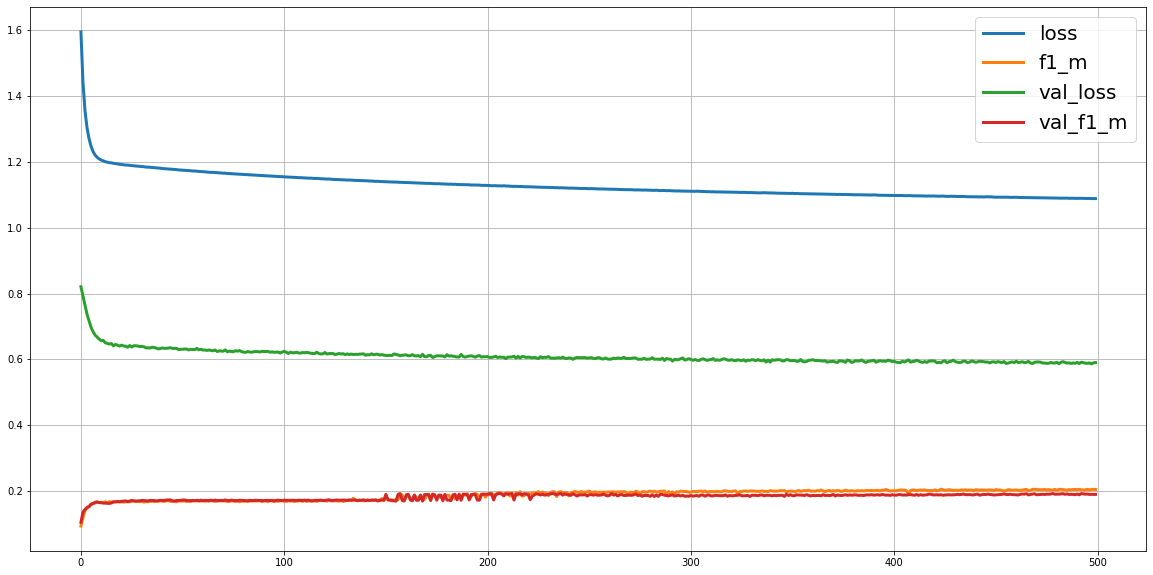

In [ ]:
#Printing out the model history for the model
pd.DataFrame(history.history).plot(figsize=(20,10), linewidth =3)
plt.legend(fontsize = 20)
plt.grid(True)
plt.show


In [ ]:
#Converting Model outputs into readbale data and then confirming validation performance over the whole validation set.
Dense3Layer_val = Dense3Layer.evaluate(X_val_scaled, y_val)

207/207 [==============================] - 0s 2ms/step - loss: 0.5908 - f1_m: 0.1755


#####Predicting Test data and saving to CSV

In [ ]:
#Using the Model to predict the test set and save down the CSV. 
ThreeLayerpreds =Dense3Layer.predict(test_data)
D3Layerpreds = []
for i in ThreeLayerpreds:
  if i >= 0.5:
    D3Layerpreds.append(1)
  else:
    D3Layerpreds.append(0)

D3Lpred = pd.DataFrame(D3Layerpreds)
D3Lpred.columns = ['psrel']
D3Lpred = pd.concat([test_w_id['Id'], D3Lpred], axis=1) #concatenate ID of each song with its prediction
D3Lpred = D3Lpred.astype(int)

#Export file to csv ready to upload
D3Lpred.to_csv("D3L_predictions.csv", index=False)

####Dense3Layer on Augmented Data

In [ ]:
#Compiling the model with optimiser, loss and performance metrics. Class weight confirmed again in cell.
Dense3Layer.compile(
    optimizer =keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics = [f1_m]) 

class_weight = {0: 1,
               1:16 }

In [ ]:
history = Dense3Layer.fit(X_aug_scaled,y_aug,
                    epochs= 500,
                    batch_size= 20000,
                    class_weight = class_weight,
                    validation_data =(X_aug_val_scaled, y_aug_val))

Epoch 1/500
23/23 [==============================] - 1s 14ms/step - loss: 1.1109 - f1_m: 0.1870 - val_loss: 0.5904 - val_f1_m: 0.1785
Epoch 2/500
23/23 [==============================] - 0s 6ms/step - loss: 1.1180 - f1_m: 0.1875 - val_loss: 0.5885 - val_f1_m: 0.2010
Epoch 3/500
23/23 [==============================] - 0s 6ms/step - loss: 1.1182 - f1_m: 0.1878 - val_loss: 0.5848 - val_f1_m: 0.2028
Epoch 4/500
23/23 [==============================] - 0s 6ms/step - loss: 1.1135 - f1_m: 0.1890 - val_loss: 0.5875 - val_f1_m: 0.1792
Epoch 5/500
23/23 [==============================] - 0s 6ms/step - loss: 1.1107 - f1_m: 0.1872 - val_loss: 0.5885 - val_f1_m: 0.1792
Epoch 6/500
23/23 [==============================] - 0s 6ms/step - loss: 1.1128 - f1_m: 0.1890 - val_loss: 0.5862 - val_f1_m: 0.1801
Epoch 7/500
23/23 [==============================] - 0s 6ms/step - loss: 1.1112 - f1_m: 0.1885 - val_loss: 0.5867 - val_f1_m: 0.1788
Epoch 8/500
23/23 [==============================] - 0s 6ms/step - l

<function matplotlib.pyplot.show>

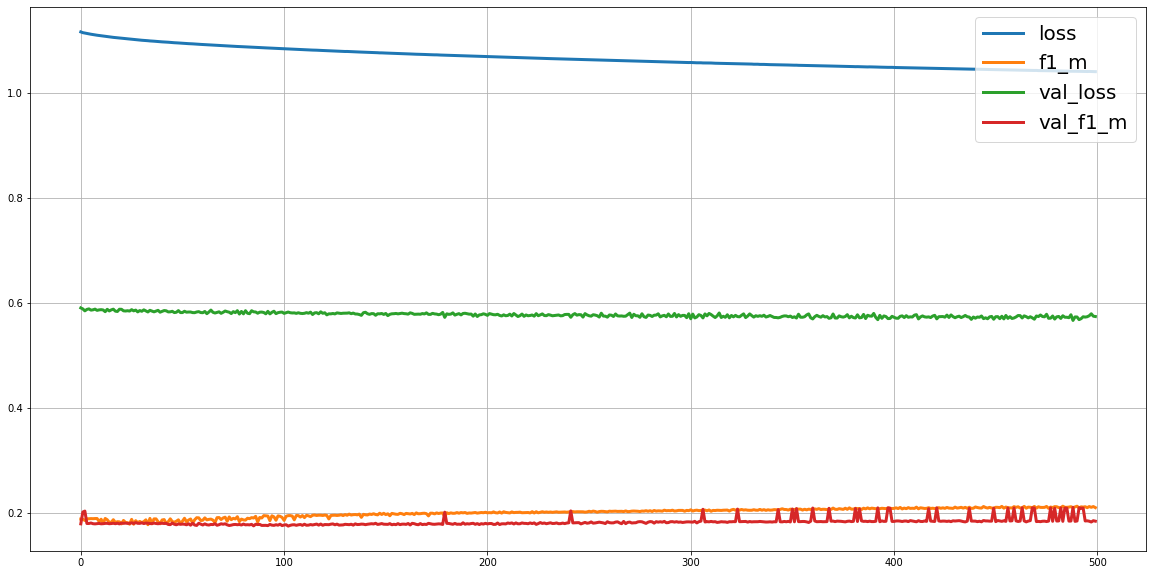

In [ ]:
#Printing out the model history for the model
pd.DataFrame(history.history).plot(figsize=(20,10), linewidth =3)
plt.legend(fontsize = 20)
plt.grid(True)
plt.show


In [ ]:
#Converting Model outputs into readbale data and then confirming validation performance over the whole validation set.
Dense3Layer_val = Dense3Layer.evaluate(X_val_scaled, y_val)

207/207 [==============================] - 0s 2ms/step - loss: 0.5582 - f1_m: 0.2057


#####Predicting augmented data and saving to CSV

In [ ]:
#Using the Model to predict the test set and save down the CSV. 
ThreeLayerpreds =Dense3Layer.predict(test_data)
D3Layerpreds = []
for i in ThreeLayerpreds:
  if i >= 0.5:
    D3Layerpreds.append(1)
  else:
    D3Layerpreds.append(0)

D3Lpred = pd.DataFrame(D3Layerpreds)
D3Lpred.columns = ['psrel']
D3Lpred = pd.concat([test_w_id['Id'], D3Lpred], axis=1) #concatenate ID of each song with its prediction
D3Lpred = D3Lpred.astype(int)

#Export file to csv ready to upload
D3Lpred.to_csv("D3L__Aug_predictions.csv", index=False)

### Multilayer Model - Model 3

In [ ]:
class MultiLayer(tf.keras.Model):
    
    def __init__(self, units = 300, activation = 'selu', out_activation = 'sigmoid',
                 initializer = 'LecunNormal', l2= 0.001,
                 **kwargs):
        super(MultiLayer, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units*2, activation= activation, kernel_initializer = initializer,kernel_regularizer =keras.regularizers.l2(l2))
        self.dense2 = tf.keras.layers.Dense(units, activation= activation, kernel_initializer = initializer,kernel_regularizer =keras.regularizers.l2(l2))
        self.dense3 = tf.keras.layers.Dense(units, activation= activation, kernel_initializer = initializer,kernel_regularizer =keras.regularizers.l2(l2))
        self.dense4 = tf.keras.layers.Dense(units, activation= activation, kernel_initializer = initializer,kernel_regularizer =keras.regularizers.l2(l2))
        self.dense5 = tf.keras.layers.Dense(units, activation= activation, kernel_initializer = initializer,kernel_regularizer =keras.regularizers.l2(l2))
        self.main_out = tf.keras.layers.Dense(units = 1, activation= out_activation,  kernel_initializer = 'GlorotNormal')
        
    def call(self, inputs):
        inputs = inputs
        keras.layers.BatchNormalization()
        dense1 = self.dense1(inputs)
        keras.layers.BatchNormalization()
        dense2 = self.dense2(dense1)
        keras.layers.BatchNormalization()
        dense3 = self.dense3(dense2)
        keras.layers.BatchNormalization()
        dense4 = self.dense4(dense3)
        keras.layers.BatchNormalization()
        dense5 = self.dense5(dense4)
        keras.layers.BatchNormalization()
        main_out = self.main_out(dense5)
        return main_out
        
MultiLayer = MultiLayer()

####Multilayer Model on Training data

In [ ]:
#Compiling Model 3 Training 
MultiLayer.compile(
    optimizer =keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics = [f1_m])

class_weight = {0: 1,
               1:16 }

In [ ]:
#Training Schedule
history = MultiLayer.fit(X_train_scaled,y_train,
                 epochs= 250,
                 callbacks=[lr_schedular],
                 batch_size= 500,
                 class_weight = class_weight,
                 validation_data =(X_val_scaled, y_val))

Epoch 1/250
53/53 [==============================] - 1s 9ms/step - loss: 3.4429 - f1_m: 0.1507 - val_loss: 2.3081 - val_f1_m: 0.1393
Epoch 2/250
53/53 [==============================] - 0s 4ms/step - loss: 2.9048 - f1_m: 0.1589 - val_loss: 2.3023 - val_f1_m: 0.1831
Epoch 3/250
53/53 [==============================] - 0s 5ms/step - loss: 2.7726 - f1_m: 0.1778 - val_loss: 2.0837 - val_f1_m: 0.1766
Epoch 4/250
53/53 [==============================] - 0s 5ms/step - loss: 2.6464 - f1_m: 0.1783 - val_loss: 2.1899 - val_f1_m: 0.1598
Epoch 5/250
53/53 [==============================] - 0s 5ms/step - loss: 2.6050 - f1_m: 0.1742 - val_loss: 2.0174 - val_f1_m: 0.1844
Epoch 6/250
53/53 [==============================] - 0s 4ms/step - loss: 2.4684 - f1_m: 0.1911 - val_loss: 1.8917 - val_f1_m: 0.1983
Epoch 7/250
53/53 [==============================] - 0s 4ms/step - loss: 2.4033 - f1_m: 0.2106 - val_loss: 1.7936 - val_f1_m: 0.2104
Epoch 8/250
53/53 [==============================] - 0s 4ms/step - lo

<function matplotlib.pyplot.show>

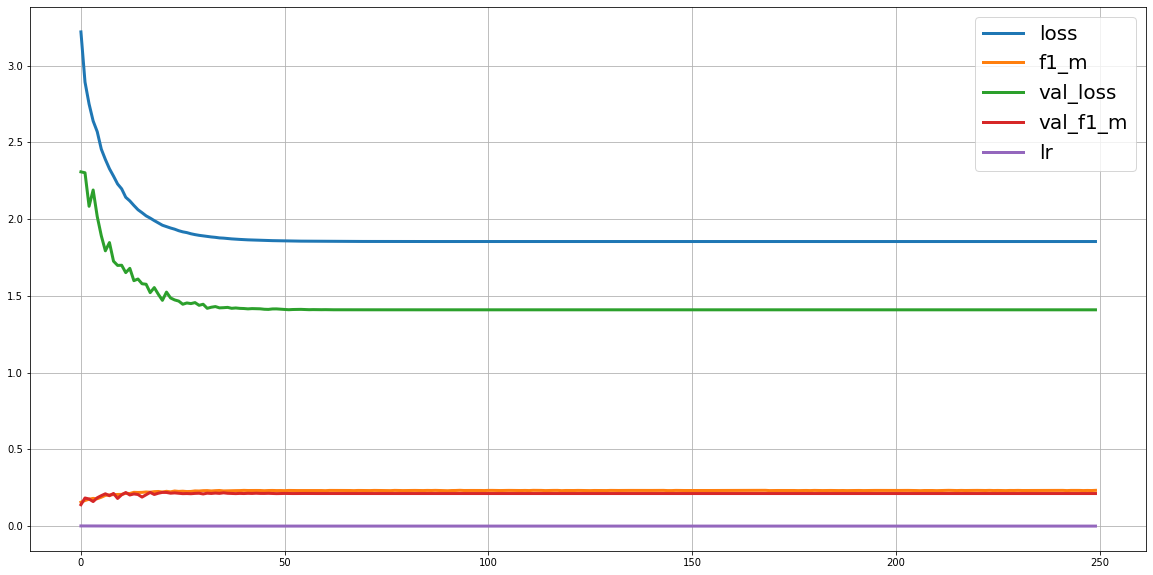

In [ ]:
#Printing out the model history for the model
pd.DataFrame(history.history).plot(figsize=(20,10), linewidth =3)
plt.legend(fontsize = 20)
plt.grid(True)
plt.show

In [ ]:
multiLayer_val = MultiLayer.evaluate(X_val_scaled, y_val)

207/207 [==============================] - 0s 2ms/step - loss: 1.4092 - f1_m: 0.1871


In [ ]:
#Predicting and saving output on training set 

MultiLayer_preds =MultiLayer.predict(test_data)

ML_preds = []
for i in MultiLayer_preds:
  if i >= 0.5:
    ML_preds.append(1)
  else:
    ML_preds.append(0)

MLpred = pd.DataFrame(ML_preds)
MLpred.columns = ['psrel']
MLpred = pd.concat([test_w_id['Id'], MLpred], axis=1) #concatenate ID of each song with its prediction
MLpred = MLpred.astype(int)

#Export file to csv ready to upload
MLpred.to_csv("ML_predictions.csv", index=False)

####Multilayer Model on augmented data


In [ ]:
#Compiling Model 3 Training 
MultiLayer.compile(
    optimizer =keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics = [f1_m])

class_weight = {0: 1,
               1:16 }

In [ ]:
#Training Schedule
history = MultiLayer.fit(X_aug_scaled,y_aug,
                 epochs= 250,
                 callbacks=[lr_schedular],
                 batch_size= 40000,
                 class_weight = class_weight,
                 validation_data =(X_aug_val_scaled, y_aug_val))

Epoch 1/250
12/12 [==============================] - 2s 57ms/step - loss: 2.0871 - f1_m: 0.1765 - val_loss: 1.4251 - val_f1_m: 0.1985
Epoch 2/250
12/12 [==============================] - 0s 33ms/step - loss: 1.9126 - f1_m: 0.1920 - val_loss: 1.3733 - val_f1_m: 0.1865
Epoch 3/250
12/12 [==============================] - 0s 33ms/step - loss: 1.8505 - f1_m: 0.2004 - val_loss: 1.3302 - val_f1_m: 0.1848
Epoch 4/250
12/12 [==============================] - 0s 33ms/step - loss: 1.8010 - f1_m: 0.2035 - val_loss: 1.2880 - val_f1_m: 0.2183
Epoch 5/250
12/12 [==============================] - 0s 33ms/step - loss: 1.7645 - f1_m: 0.2106 - val_loss: 1.2766 - val_f1_m: 0.2114
Epoch 6/250
12/12 [==============================] - 0s 33ms/step - loss: 1.7256 - f1_m: 0.2112 - val_loss: 1.2490 - val_f1_m: 0.2103
Epoch 7/250
12/12 [==============================] - 0s 33ms/step - loss: 1.6963 - f1_m: 0.2125 - val_loss: 1.2253 - val_f1_m: 0.1934
Epoch 8/250
12/12 [==============================] - 0s 33ms/s

<function matplotlib.pyplot.show>

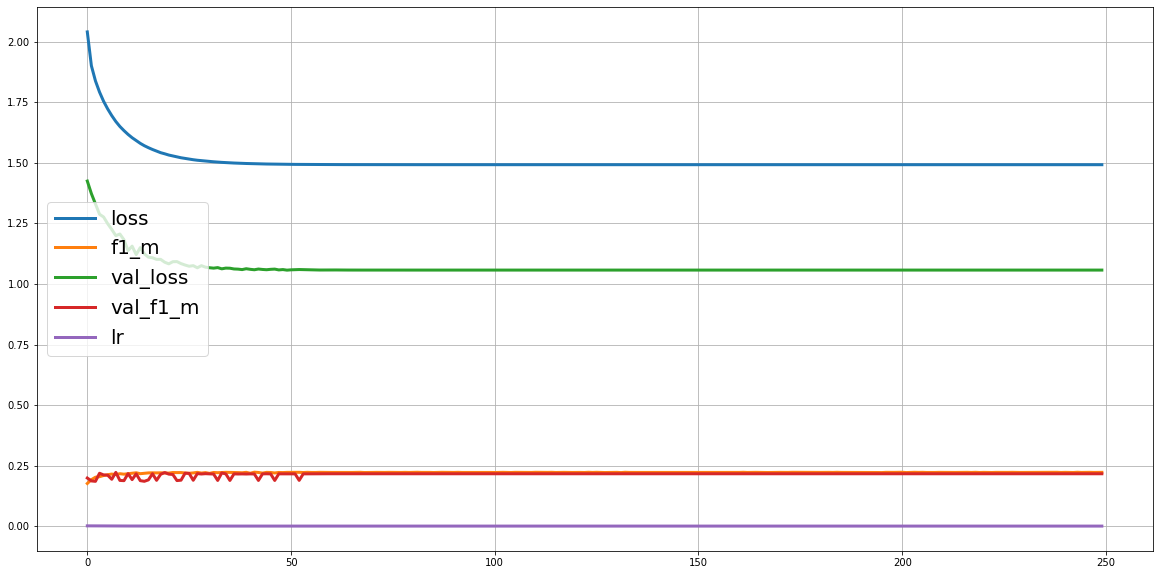

In [ ]:
#Printing out the model history for the model
pd.DataFrame(history.history).plot(figsize=(20,10), linewidth =3)
plt.legend(fontsize = 20)
plt.grid(True)
plt.show

In [ ]:
AugML_val = MultiLayer.evaluate(X_aug_val_scaled, y_aug_val)

258/258 [==============================] - 1s 2ms/step - loss: 1.0574 - f1_m: 0.2034


In [ ]:
#Preicting and saving output on training set 

MultiLayer_preds =MultiLayer.predict(test_data)

ML_preds = []
for i in MultiLayer_preds:
  if i >= 0.5:
    ML_preds.append(1)
  else:
    ML_preds.append(0)

MLpred = pd.DataFrame(ML_preds)
MLpred.columns = ['psrel']
MLpred = pd.concat([test_w_id['Id'], MLpred], axis=1) #concatenate ID of each song with its prediction
MLpred = MLpred.astype(int)

#Export file to csv ready to upload
MLpred.to_csv("ML__aug_predictions.csv", index=False)

### Alternate Architecture - Model 4


In [ ]:
#SubClass Creation
class AltArchi(tf.keras.Model):

    def __init__(self, units = 6, activation ='selu', out_activation = 'sigmoid',
                 initializer = 'LecunNormal', initializer2 = 'he_normal', **kwargs):
        super(AltArchi, self).__init__()
        #Defining Deep Layers and Output Layers
      
        self.Dense_Layer_1 = tf.keras.layers.Dense(units, activation= activation, kernel_initializer = initializer, kernel_regularizer= keras.regularizers.l2(0.01))
        self.Dense_Layer_2 = tf.keras.layers.Dense(units, activation= activation, kernel_initializer = initializer, kernel_regularizer= keras.regularizers.l2(0.01))
        self.Dense_Layer_3 = tf.keras.layers.Dense(units, activation= activation, kernel_initializer = initializer, kernel_regularizer= keras.regularizers.l2(0.01))
        self.Dense_Layer_4 = tf.keras.layers.Dense(units, activation= activation, kernel_initializer = initializer, kernel_regularizer= keras.regularizers.l2(0.01))
        self.Dense_Layer_5 = tf.keras.layers.Dense(units, activation= activation, kernel_initializer = initializer, kernel_regularizer= keras.regularizers.l2(0.01))
        self.Dense_Layer_6 = tf.keras.layers.Dense(units, activation= activation, kernel_initializer = initializer, kernel_regularizer= keras.regularizers.l2(0.01))
        self.Dense_Layer_7 = tf.keras.layers.Dense(units, activation= activation, kernel_initializer = initializer, kernel_regularizer= keras.regularizers.l2(0.01))
        self.Dense_Layer_8 = tf.keras.layers.Dense(units, activation= activation, kernel_initializer = initializer, kernel_regularizer= keras.regularizers.l2(0.01))
        self.Dense_Layer_9 = tf.keras.layers.Dense(units, activation= activation, kernel_initializer = initializer, kernel_regularizer= keras.regularizers.l2(0.01))
        self.Dense_Layer_10 = tf.keras.layers.Dense(units, activation= activation, kernel_initializer = initializer, kernel_regularizer= keras.regularizers.l2(0.01))
        
        self.Output_Layer = tf.keras.layers.Dense(units = 1, activation= out_activation,  kernel_initializer = 'GlorotNormal')
        
        #Defining Input structure Layers.
        self.User_Inputs = tf.keras.layers.Input((1,), dtype='int32', name='User_in')
        self.Cpvs_Inputs = tf.keras.layers.Input((max_length,), dtype='int32', name='Cpvs_inputs')
        self.Rest_Inputs = tf.keras.layers.Input((22,), name='Rest_inputs')
        
        self.Embedding_layer_cpvs = tf.keras.layers.Embedding(4686, 12, input_length=max_length)
        self.Embedding_layer_user = tf.keras.layers.Embedding(1172, 5, input_length=1)
        
    def call(self,inputs):
        User_Inputs = inputs[0]
        Cpvs_Inputs = inputs[1]
        Rest_Inputs = inputs[2]
        
        
        #Embedding User and Cpvs Data.
        user = self.Embedding_layer_user(User_Inputs)
        cpvs = self.Embedding_layer_cpvs(Cpvs_Inputs)
        #Flattening User and Cpvs Data.
        user = tf.keras.layers.Flatten()(user)
        cpvs = tf.keras.layers.Flatten()(cpvs)      
        
        Concatinated_inputs = tf.keras.layers.Concatenate()([user, cpvs, Rest_Inputs])

        keras.layers.BatchNormalization()
        tf.keras.layers.Dropout(rate = 0.2)
        Dense_Output = self.Dense_Layer_1(Concatinated_inputs)

        keras.layers.BatchNormalization()
        tf.keras.layers.Dropout(rate = 0.2)
        Dense_Output2 = self.Dense_Layer_2(Dense_Output)

        keras.layers.BatchNormalization()
        tf.keras.layers.Dropout(rate = 0.2)
        Dense_Output3 = self.Dense_Layer_3(Dense_Output2)

        Dense_Output31 = tf.keras.layers.Concatenate()([Dense_Output3,Dense_Output])
        keras.layers.BatchNormalization()
        tf.keras.layers.Dropout(rate = 0.2)
        Dense_Output4 = self.Dense_Layer_4(Dense_Output31)

        keras.layers.BatchNormalization()
        tf.keras.layers.Dropout(rate = 0.2)
        Dense_Output5 = self.Dense_Layer_5(Dense_Output4)

        keras.layers.BatchNormalization()
        tf.keras.layers.Dropout(rate = 0.2)
        Dense_Output6 = self.Dense_Layer_6(Dense_Output5)

        Dense_Output61 = tf.keras.layers.Concatenate()([Dense_Output6,Dense_Output4])
        keras.layers.BatchNormalization()
        tf.keras.layers.Dropout(rate = 0.2)
        Dense_Output7 = self.Dense_Layer_7(Dense_Output61)

        keras.layers.BatchNormalization()
        tf.keras.layers.Dropout(rate = 0.2)
        Dense_Output8 = self.Dense_Layer_8(Dense_Output7)

        keras.layers.BatchNormalization()
        tf.keras.layers.Dropout(rate = 0.2)
        Dense_Output9 = self.Dense_Layer_9(Dense_Output8)

        Dense_Output91 = tf.keras.layers.Concatenate()([Dense_Output9,Dense_Output7])
        keras.layers.BatchNormalization()
        tf.keras.layers.Dropout(rate = 0.2)
        Dense_Output10 = self.Dense_Layer_10(Dense_Output91)
        
        keras.layers.BatchNormalization()
        tf.keras.layers.Dropout(rate = 0.2)
        Output_Layer = self.Output_Layer(Dense_Output10)
        
        return Output_Layer
        
AltArchi = AltArchi()

#####Alternaitve Arcatecture on training data

In [ ]:
AltArchi.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics = [f1_m])

weights = {0: 1,
           1: 16}

history = AltArchi.fit((user_train_inputs, cpvs_train_inputs, X_num_scaled),
                       y_train, 
                    epochs = 25, 
                    validation_data=((user_val_inputs, cpvs_val_inputs, X_num_scaled_val), y_val), 
                    class_weight=weights,
                    callbacks = [lr_schedular],
                    batch_size=500)

Epoch 1/25
53/53 [==============================] - 3s 15ms/step - loss: 1.8529 - f1_m: 0.0700 - val_loss: 1.1794 - val_f1_m: 0.1162
Epoch 2/25
53/53 [==============================] - 0s 9ms/step - loss: 1.7380 - f1_m: 0.1022 - val_loss: 1.0958 - val_f1_m: 0.1121
Epoch 3/25
53/53 [==============================] - 0s 8ms/step - loss: 1.6720 - f1_m: 0.0986 - val_loss: 1.0275 - val_f1_m: 0.1051
Epoch 4/25
53/53 [==============================] - 0s 8ms/step - loss: 1.6217 - f1_m: 0.1187 - val_loss: 0.9373 - val_f1_m: 0.0705
Epoch 5/25
53/53 [==============================] - 0s 8ms/step - loss: 1.5438 - f1_m: 0.1373 - val_loss: 0.9497 - val_f1_m: 0.0964
Epoch 6/25
53/53 [==============================] - 0s 8ms/step - loss: 1.4567 - f1_m: 0.1878 - val_loss: 1.0053 - val_f1_m: 0.1036
Epoch 7/25
53/53 [==============================] - 0s 8ms/step - loss: 1.3454 - f1_m: 0.2178 - val_loss: 0.8801 - val_f1_m: 0.0972
Epoch 8/25
53/53 [==============================] - 0s 8ms/step - loss: 1.2

In [ ]:
AltArchi.evaluate((user_val_inputs, cpvs_val_inputs, X_num_scaled_val), y_val)

207/207 [==============================] - 1s 3ms/step - loss: 0.7538 - f1_m: 0.0892


[0.753772497177124, 0.08917836099863052]

<function matplotlib.pyplot.show>

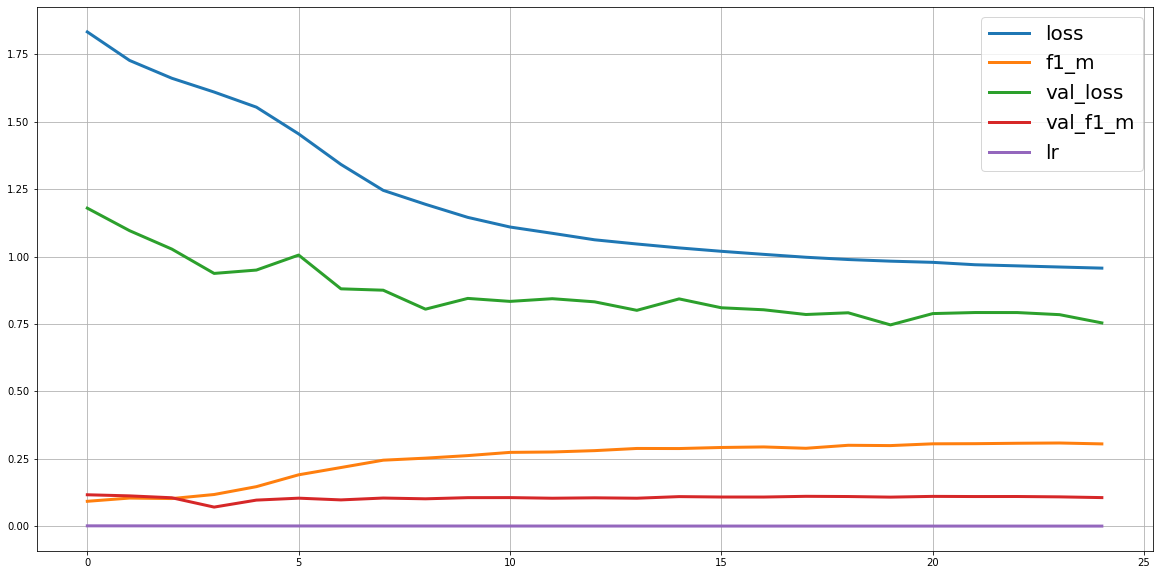

In [ ]:
pd.DataFrame(history.history).plot(figsize=(20,10), linewidth =3)
plt.legend(fontsize = 20)
plt.grid(True)
#plt.gca().set_ylim(0,1)
plt.show

In [ ]:
predictions = AltArchi.predict((user_test_inputs,cpvs_test_inputs, num_test_scaled))
results = []
for i in predictions:
    if i >= 0.5:
        results.append(1)
    else:
        results.append(0)
    
Archpred = pd.DataFrame(results)
Archpred.columns = ['psrel']
Archpred = pd.concat([test_w_id['Id'], Archpred], axis=1) #concatenate ID of each song with its prediction
Archpred = Archpred.astype(int)

#Export file to csv ready to upload
Archpred.to_csv("Arch_predictions.csv", index=False)

####Alternative Architecture with Augmented Data

In [ ]:
AltArchi.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics = [f1_m])

weights = {0: 1,
           1: 16}

history = AltArchi.fit((aug_user_train_inputs,aug_cpvs_train_inputs,num_train_scaled), 
                    y_emb_aug_Train, 
                    epochs = 25, 
                    validation_data=((aug_user_val_inputs, aug_cpvs_val_inputs, num_val_scaled), y_emb_aug_val), 
                    class_weight=weights,
                    callbacks = [lr_schedular],
                    batch_size=40000)

Epoch 1/25
12/12 [==============================] - 5s 230ms/step - loss: 1.7796 - f1_m: 0.1575 - val_loss: 0.7021 - val_f1_m: 0.2262
Epoch 2/25
12/12 [==============================] - 2s 196ms/step - loss: 1.2335 - f1_m: 0.2652 - val_loss: 0.6557 - val_f1_m: 0.2776
Epoch 3/25
12/12 [==============================] - 2s 200ms/step - loss: 1.0720 - f1_m: 0.3379 - val_loss: 0.6011 - val_f1_m: 0.3346
Epoch 4/25
12/12 [==============================] - 2s 194ms/step - loss: 0.9625 - f1_m: 0.4029 - val_loss: 0.5716 - val_f1_m: 0.3630
Epoch 5/25
12/12 [==============================] - 2s 196ms/step - loss: 0.8743 - f1_m: 0.4524 - val_loss: 0.5258 - val_f1_m: 0.3943
Epoch 6/25
12/12 [==============================] - 2s 195ms/step - loss: 0.8038 - f1_m: 0.4964 - val_loss: 0.5173 - val_f1_m: 0.4026
Epoch 7/25
12/12 [==============================] - 2s 196ms/step - loss: 0.7505 - f1_m: 0.5136 - val_loss: 0.4888 - val_f1_m: 0.4166
Epoch 8/25
12/12 [==============================] - 2s 199ms/s

In [ ]:
AugAlt_val = AltArchi.evaluate((aug_user_val_inputs, aug_cpvs_val_inputs, num_val_scaled), y_emb_aug_val)

258/258 [==============================] - 1s 3ms/step - loss: 0.4514 - f1_m: 0.3766


<function matplotlib.pyplot.show>

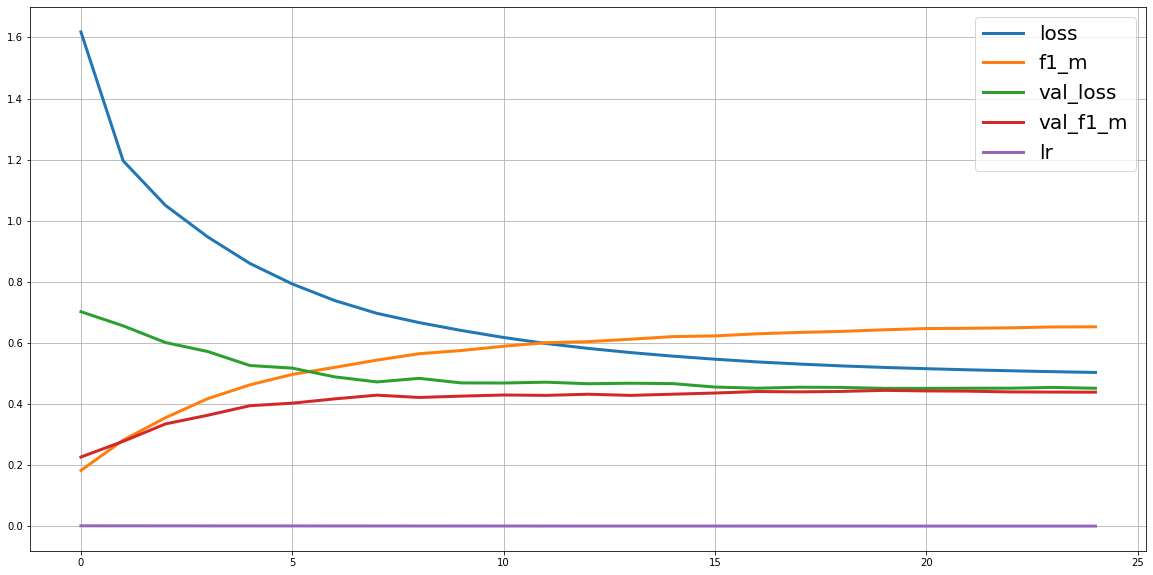

In [ ]:
pd.DataFrame(history.history).plot(figsize=(20,10), linewidth =3)
plt.legend(fontsize = 20)
plt.grid(True)
#plt.gca().set_ylim(0,1)
plt.show

In [ ]:
predictions = AltArchi.predict((user_test_inputs, cpvs_test_inputs, num_test_scaled))
results = []
for i in predictions:
    if i >= 0.5:
        results.append(1)
    else:
        results.append(0)
    
AugArchpred = pd.DataFrame(results)
AugArchpred.columns = ['psrel']
AugArchpred = pd.concat([test_w_id['Id'], AugArchpred], axis=1) #concatenate ID of each song with its prediction
AugArchpred = AugArchpred.astype(int)

#Export file to csv ready to upload
AugArchpred.to_csv("AugArch_predictions.csv", index=False)

#Additional Attempts to improve performance
We attempted many different complex architectures, many reaching above .19 on kaggle. Surprisingly, a basic 5 layer dense model using embedding with 5000 neruons per layer was able to reach .19.

We opted for an architecture inspired by res net as it was the most consistent and highest scoring. We found that hyper parameter tuning was not optimal within this task, as the gap between validation score using the training set and the test set was very big. Therefore, fine tuning the model on the validation set any more is likely going to lead to a less generalizable model for the client.  

Furthermore, we attempted dense layers for each input before concationation in the alternate Architecture, but we should this lead to poorer performing models overall.

#Training Approach

We manually attemped Relu, Selu, Tanh and elu functions for each model, with all performing comparitively simiar with a small advantage for Selu. Scheduled learning rate meant that the model always converged and learning rate never needed tweeked. Manual inspection of model history allowed for logical changes to epoch count and batch size as appropriate.


We found that most hyper parameters performed similarly and therefore we opted to focus our reasources in attemping better data processing techniques and network arcitectures to improve model performance and this approach proved successful.

# Results and Discussion

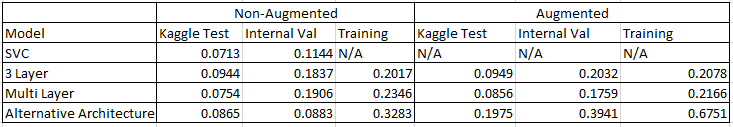

Please see model descriptions and subclass codes for hyper parameters.



#Findings 

- As can be seen within the table, models perform better when they are trained on more data. Using limited categorical data, the dense 3-layer model (model 2) achieved validation f1 scores of 0.2, however when submitting to Kaggle, the score obtained on the testing data was of 0.09.

- The dense deep model (model 3) performed comparatively poor to the previous model, scoring at best 0.19 on validation data and 0.086 in Kaggle. Perhaps being a deeper network training was not as efficient due to unstable gradients.

- The final model, with a alternate architecture (model 4), scores validation f1 scores circa 0.40 when trained. We attribute this to the embedding layers using complex data, and the skip layers assisting consistant learning throughout all layers.

- Models do not tend to overfit but rather converge.

We note that the additonal architecture doesnt perform well on non augmented data suggesting that it is very data hungry, but this should not be a problem for the client.


# Summary and Recommendation

- We found that best models always embed user and CPVS data in order to accurately extract the relationships contained. Adding embedding layers gives a significant jump of circa 0.15. Using the correct architecture with embedding layers in addition to data augmentation allowed us to reach a score of .1975 on kaggle. We believe embedding input layers and skip layers to be the most effienct tactic available (META) for this task. 

- The non-user-Id-data is important and can give a reasonable predictor of relevance but applying them to each customer is key. We did not find session Id to be impactful with embedding layers. 

- We would emplore the client to use embedding layers going forward to act as a recommender system. It is computationally expensive but unless the profit margin is low then we believe that implementation of embeddings with cloud computing services would be the appropriate way for the client to take their recommender system to production and implementation. 

- Avoid shallow NN’s and Shallow ML methods as they are not able to capure the complexity within the dataset. With embedding layers, layers with as little as 3 nuerons pefrom excellently. We would suggest investigation into much deeper neural networks when applied to the whole data set. 


# References

Embeddings for Categorizing Social Media. EMNLP Workshop W-NUT: The Sixth Workshop on Noisy User-generated Text, pp. 28-33.

Géron, A., 2019. Hands-On Machine Learning with Beijing Boston Farnham Sebastopol Tokyo Scikit-Learn, Keras, and TensorFlow. Second Edition ed. Sebastopol: O’Reilly Media, Inc..

Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. "Deep Residual Learning for Image Recognition." 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR) (2016): 770-78. Web.

# Exploratory Data Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
train_data = pd.read_csv('train.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0    31038
1     1962
Name: psrel, dtype: int64


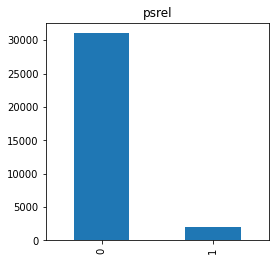

In [ ]:
# This plot shows the ratio of relevant results to non relevant results. The ratio is roughly 16:1
print(train_data['psrel'].value_counts())
train_data['psrel'].value_counts().plot(kind='bar',
                                    figsize=(4,4),
                                    title="psrel")

### Removed Variables

In [ ]:
#print(train_data[['new-sub','psrel']].groupby('new-sub').agg(['count','sum']))
print('Old Sub Ratio', 391/6705)
print('New Sub Ratio', 1571/26295)

#New sub does not seem to be relevant in isolation. It will be removed for inital modelling.

Old Sub Ratio 0.05831469052945563
New Sub Ratio 0.05974519870697851


In [ ]:
#print(train_data[['premium-pack','psrel']].groupby('premium-pack').agg(['count','sum']))
print('1st Page', 1578/26731)
print('2nd Page', 384/6269)

#Premium Pack does not seem to be relevant in isolation.

1st Page 0.05903258389136209
2nd Page 0.06125378848301165


### Sub-Categorised Variables

In [ ]:
#Dwell does not seem to be important between 0-2 minutes even in 15 second incriments.
print(285/4202)
print(139/2216)
print(84/1329)
print(1034/18569)
print(420/6684)

0.06782484531175631
0.06272563176895307
0.06320541760722348
0.055684204857558296
0.06283662477558348


Mar    9229
Jun    6527
Apr    4551
Feb    4545
May    4114
Jan    4034
Name: month, dtype: int64


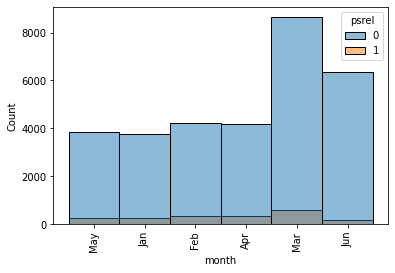

In [ ]:
#Only February, March, and April seem relevant here
print(train_data['month'].value_counts())
plt.xticks(rotation=90)
sns.histplot(data=train_data, x="month", hue='psrel')

In [ ]:
#Nature is the grouping of the industry, with a lot of Nas that will be sub-classed as other
print(train_data['nature'].value_counts())

services    15506
supplies     3146
works        2946
Name: nature, dtype: int64


#Data Preprocessing


##Importing Packages and Creating Data Cleaning Functions

In [ ]:
pip install gensim

In [ ]:

###Importing relevant Libraries and functions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ast
from collections import Counter

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from collections import Counter
from sklearn.feature_extraction import FeatureHasher

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split, StratifiedKFold


import tensorflow as tf
import keras 

from tensorflow.math import confusion_matrix
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Embedding, Dense, Dropout


In [ ]:
#Creating Performance Metrics that do not come with keras and SKlearn
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
#For general data cleaning
def categorise_dwell(x):
    value = "6"
    if pd.notnull(x):
        if 0 <= x < 15:
            value = "1"
        elif 15 <= x < 30:
            value = "2"
        elif 30 <= x < 45:
            value = "3"
        elif 45 <= x < 60:
            value = "4"
        else: value= '5'
    return value

def categorise_nature(x):
    value = "Other"
    if pd.notnull(x):
        if "services" in x:
            value = "services"
        elif "supplies" in x:
            value = "supplies"
        elif "works" in x:
            value = "works"
        else: 
            value = "Other"
    return value

def categorise_month(x):
    value = "Other"
    if pd.notnull(x):
        if "Mar" in x:
            value = "Mar"
        elif "Apr" in x:
            value = "Apr"
        elif "May" in x:
            value = "May"
        else: 
            value = "Other"
    return value

#For Embedding:
  #Convert CPVS into list
def list_of_cpvs(x):
  list_total = []
  for i in x.index:
        if x[i] == '[]':
          list_total.append('0')
        else:
          lista = []
          for j in range(len(ast.literal_eval(x[i]))):
              lista.append(ast.literal_eval(x[i])[j])
          list_total.append(lista)

  list_uniques = []
  for i in range(len(list_total)):
      list_uniques.append(list(set(list_total[i])))
  return(list_uniques)

  #Creates a list of all CPVS
def all_existing_cpvs(x):
    listb = []
    for i in range(len(x)):
        for j in range(len(ast.literal_eval(x[i]))):
            listb.append(ast.literal_eval(x[i])[j][:2])
    return(listb)
  #Converts lists back to strings
def list_to_strings(x):
  joined_cpvs = []
  for i in range(len(x)):
    joined_cpvs.append(' '.join(x[i]))
  return(joined_cpvs)
  #Converts lists back to strings
def list_to_strings2(x):
    strings = []
    for i in range(len(x)):
        strings.append(str(x[i]))
    return(strings)

In [ ]:
#Data cleaning function for validation for augmented data
def data_cleaning_non_emb(train_data):
    train_data['month'] = train_data['month'].apply(categorise_month)
    train_data['dwell'] = train_data['dwell'].apply(categorise_dwell)

    ohe = OneHotEncoder(categories='auto', drop= 'first')
    feature_arr = ohe.fit_transform(train_data[['search','month','source','type']]).toarray()
    features = pd.DataFrame(feature_arr)
    train_data.reset_index(inplace=True)

    train_data = pd.concat([train_data, features], axis=1)
    train_data.drop(['index'], axis=1, inplace=True)

    train_data.drop(['search','month','source','type','nature'], axis =1, inplace=True)
    train_data = train_data.drop(['user','cpvs','session','query','timestamp','day','hour','new-sub','premium-pack','#cpv45','rank'], axis=1)
    train_data.dropna(inplace = True)
    return(train_data)

In [ ]:
#Data cleaning function for non-embedding data
def data_cleaning2_non_emb(train_data):
    train_data['month'] = train_data['month'].apply(categorise_month)
    train_data['dwell'] = train_data['dwell'].apply(categorise_dwell)

    ohe = OneHotEncoder(categories='auto', drop= 'first')
    feature_arr = ohe.fit_transform(train_data[['search','month','source','type']]).toarray()
    features = pd.DataFrame(feature_arr)
    

    train_data = pd.concat([train_data, features], axis=1)

    train_data.drop(['search','month','source','type','nature'], axis =1, inplace=True)
    train_data = train_data.drop(['user','cpvs','session', 'query','timestamp','day','hour','new-sub','premium-pack','#cpv45','rank'], axis=1)
    train_data.dropna(inplace = True)
    return(train_data)

In [ ]:
#Data cleaning function for validation set for embedding
def data_cleaning(train_data):
    train_data['month'] = train_data['month'].apply(categorise_month)
    train_data['dwell'] = train_data['dwell'].apply(categorise_dwell)

    ohe = OneHotEncoder(categories='auto', drop= 'first')
    feature_arr = ohe.fit_transform(train_data[['search','month','source','type']]).toarray()
    features = pd.DataFrame(feature_arr)
    train_data.reset_index(inplace=True)

    train_data = pd.concat([train_data, features], axis=1)
    train_data.drop(['index'], axis=1, inplace=True)

    train_data.drop(['search','month','source','type','nature'], axis =1, inplace=True)
    train_data = train_data.drop(['session','query','timestamp','day','hour','new-sub','premium-pack','#cpv45','rank'], axis=1)
    train_data.dropna(inplace = True)
    return(train_data)

In [ ]:
#Data cleaning function for augmented data for embedding
def data_cleaning2(train_data):
    train_data['month'] = train_data['month'].apply(categorise_month)
    train_data['dwell'] = train_data['dwell'].apply(categorise_dwell)

    ohe = OneHotEncoder(categories='auto', drop= 'first')
    feature_arr = ohe.fit_transform(train_data[['search','month','source','type']]).toarray()
    features = pd.DataFrame(feature_arr)
    

    train_data = pd.concat([train_data, features], axis=1)

    train_data.drop(['search','month','source','type','nature'], axis =1, inplace=True)
    train_data = train_data.drop(['session', 'query','timestamp','day','hour','new-sub','premium-pack','#cpv45','rank'], axis=1)
    train_data.dropna(inplace = True)
    return(train_data)

##Processing Data for Non-Embedding Models

### Non-Augmented Data

In [ ]:
#Import and clean non-embedding, non-augmentation data
#read data
train_data = pd.read_csv('train.csv', low_memory = False)
#apply data cleaning2
data = (data_cleaning2_non_emb(train_data))

In [ ]:
#Split non-embedding, non-augmentation data
X = data.drop('psrel', axis=1)
y = data['psrel']
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
skf.split(X, y)
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2)
X_train_scaled = std_scaler.fit_transform(X_train)
X_val_scaled = std_scaler.transform(X_val)

### Augmented Data

In [ ]:
#Splitting into Train + Val
train_data_real = pd.read_csv('train.csv', low_memory = False)

X = train_data_real.drop(['psrel'], axis=1)
y = train_data_real['psrel']

X_train, X_val_real, y, y_val_real = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [ ]:
#Creating, Splitting, and Scaling Validation Dataset for Augmented Data (with only real data)
validation = pd.concat([X_val_real, y_val_real], axis=1)
validation1 = validation.copy()
val_for_aug = data_cleaning_non_emb(validation)
X_aug_val = val_for_aug.drop('psrel', axis=1)
y_aug_val = val_for_aug['psrel']
X_aug_val_scaled = std_scaler.fit_transform(X_aug_val)

In [ ]:
#Creating Training Data
augm_data = pd.concat([X_train, y], axis=1)

In [ ]:
#Augmenting Data
columns = ('hour', 'day', 'new-sub','month','premium-pack', 'dwell', 'timestamp','search','rank','serp','source','type')
Augmented_Data_Frames = {}

#Looping throughs to create copies of data. Each copy of the data set has their representative column randomised. 
for key in columns:
        Augmented_Data_Frames[key] = augm_data.copy()
        temp = Augmented_Data_Frames[key][key].sample(n=24750, replace = False, random_state=42)
        Augmented_Data_Frames[key][key] = (temp.reset_index()).drop('index', axis =1)

#Adding the augmented data onto the end of origional data set.        
Augmented_Data = pd.concat([augm_data,
                            Augmented_Data_Frames['hour'],
                            Augmented_Data_Frames['hour'],
                            Augmented_Data_Frames['day'],
                            Augmented_Data_Frames['day'],
                            Augmented_Data_Frames['new-sub'],
                            Augmented_Data_Frames['new-sub'],
                            Augmented_Data_Frames['month'],
                            Augmented_Data_Frames['month'],
                            Augmented_Data_Frames['premium-pack'],
                            Augmented_Data_Frames['premium-pack'],
                            Augmented_Data_Frames['dwell'],
                            Augmented_Data_Frames['dwell'],
                            Augmented_Data_Frames['timestamp'],
                            Augmented_Data_Frames['timestamp'],
                            Augmented_Data_Frames['rank'],
                            Augmented_Data_Frames['rank'],
                            Augmented_Data_Frames['serp'],
                            Augmented_Data_Frames['serp']], ignore_index=True)

aug_data = Augmented_Data.copy()
aug_data = data_cleaning2_non_emb(aug_data)

In [ ]:
#Split Training set for Aug data
X_aug = aug_data.drop('psrel', axis=1)
y_aug = aug_data['psrel']
std_scaler = StandardScaler()
X_aug_scaled = std_scaler.fit_transform(X_aug)
#create folds for GridSearch
skf.get_n_splits(X_aug, y_aug)
skf.split(X_aug, y_aug)
#X_aug_train, X_aug_val,

<generator object _BaseKFold.split at 0x7f81e016fd50>

### Test Data

In [ ]:
#Importing,Cleaning and Scaling Test Data
test_data = pd.read_csv('test.csv')
test_clean = data_cleaning2_non_emb(test_data)
test_w_id = test_clean.copy()
test_data = test_clean.drop('Id', axis =1)
test_data = std_scaler.fit_transform(test_data)

## Processing Data for Embedding Models

### Non-Augmented Data

In [ ]:
#Read and clean non augmented embedding data
emb_train_data = pd.read_csv('train.csv', low_memory = False)
emb_train_data = (data_cleaning(emb_train_data))

In [ ]:
#Split non-augmented embedding data
X_emb = emb_train_data.drop('psrel', axis=1)
y_emb = emb_train_data['psrel']
X_emb_train, X_emb_val, y_emb_train, y_emb_val = train_test_split(X_emb, y_emb, stratify=y_emb, test_size=0.2)

### Augmented Data

In [ ]:
#Create + Split Validation Set for Augmented Embeddung Data
emb_val_for_aug  = data_cleaning(validation1)
X_emb_aug_val = emb_val_for_aug.drop('psrel', axis=1)
y_emb_aug_val = emb_val_for_aug['psrel']

In [ ]:
#Create Training set for augmented embedding data
emb_aug_data = Augmented_Data.copy()
emb_aug_data = data_cleaning2(emb_aug_data)
X_emb_aug_Train = emb_aug_data.drop('psrel', axis=1)
y_emb_aug_Train = emb_aug_data['psrel']

### Test Data

In [ ]:
emb_test_data = pd.read_csv('test.csv')
emb_test_data = data_cleaning2(emb_test_data)
emb_test_data.drop('Id', axis=1, inplace=True)

## Tokenizing For Embedding

### Non-Augmented Data

In [ ]:
###Tokenizing all existing cpvs
list_full_cpvs = list_of_cpvs(emb_train_data['cpvs'])
cpvs_strings = list_to_strings(list_full_cpvs)

max_length = 200

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(cpvs_strings)
embedded_sentences = word_tokenizer.texts_to_sequences(cpvs_strings)
padded_cpvs = pad_sequences(embedded_sentences, maxlen = max_length, padding = 'post') 

In [ ]:
#Tokenizing users
user_list = list(emb_train_data['user'])
user_list = list_to_strings2(user_list)

user_tokenizer = Tokenizer()
user_tokenizer.fit_on_texts(user_list)
embedded_users = user_tokenizer.texts_to_sequences(user_list)
padded_users = pad_sequences(embedded_users, maxlen = 1) 

In [ ]:
#Embedding training cpvs
train_cpvs_list = list_of_cpvs(X_emb_train['cpvs'])
train_cpvs = list_to_strings(train_cpvs_list)

train_tokens = word_tokenizer.texts_to_sequences(train_cpvs)
cpvs_train_inputs = pad_sequences(train_tokens, maxlen = max_length, padding = 'post') #cpvs train inputs

#Embedding validation cpvs
val_cpvs_list = list_of_cpvs(X_emb_val['cpvs'])
val_cpvs = list_to_strings(val_cpvs_list)

val_tokens = word_tokenizer.texts_to_sequences(val_cpvs)
cpvs_val_inputs = pad_sequences(val_tokens, maxlen = max_length, padding = 'post') #cpvs val inputs


#Embedding training users
train_user_list = list(X_emb_train['user'])
train_user = list_to_strings2(train_user_list)

train_tokens_user = user_tokenizer.texts_to_sequences(train_user)
user_train_inputs = pad_sequences(train_tokens_user, maxlen = 1) #user train inputs

#Embedding validation users
val_user_list = list(X_emb_val['user'])
val_user = list_to_strings2(val_user_list)

val_tokens_user = user_tokenizer.texts_to_sequences(val_user)
user_val_inputs = pad_sequences(val_tokens_user, maxlen = 1) #user validation inputs


In [ ]:
#Preparing numerical inputs
X_num_train = X_emb_train.drop('cpvs', axis=1)
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num_train)

X_num_val = X_emb_val.drop('cpvs', axis=1)
scaler = StandardScaler()
X_num_scaled_val = scaler.fit_transform(X_num_val)

### Augmented Data

In [ ]:
###Tokenizing all existing cpvs
list_full_cpvs = list_of_cpvs(emb_aug_data['cpvs'])
cpvs_strings = list_to_strings(list_full_cpvs)

max_length = 200

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(cpvs_strings)
embedded_sentences = word_tokenizer.texts_to_sequences(cpvs_strings)
padded_cpvs = pad_sequences(embedded_sentences, maxlen = max_length, padding = 'post') #cpvs inputs

In [ ]:
#Tokenizing users
user_list = list(emb_aug_data['user'])
user_list = list_to_strings2(user_list)

user_tokenizer = Tokenizer()
user_tokenizer.fit_on_texts(user_list)
embedded_users = user_tokenizer.texts_to_sequences(user_list)
padded_users = pad_sequences(embedded_users, maxlen = 1) #user inputs

In [ ]:
#Embedding training cpvs
train_cpvs_list = list_of_cpvs(X_emb_aug_Train['cpvs'])
train_cpvs = list_to_strings(train_cpvs_list)

train_tokens = word_tokenizer.texts_to_sequences(train_cpvs)
aug_cpvs_train_inputs = pad_sequences(train_tokens, maxlen = max_length, padding = 'post') #cpvs train inputs

#Embedding validation cpvs
val_cpvs_list = list_of_cpvs(X_emb_aug_val['cpvs'])
val_cpvs = list_to_strings(val_cpvs_list)

val_tokens = word_tokenizer.texts_to_sequences(val_cpvs)
aug_cpvs_val_inputs = pad_sequences(val_tokens, maxlen = max_length, padding = 'post') #cpvs val inputs

#Embedding training users
train_user_list = list(X_emb_aug_Train['user'])
train_user = list_to_strings2(train_user_list)

train_tokens_user = user_tokenizer.texts_to_sequences(train_user)
aug_user_train_inputs = pad_sequences(train_tokens_user, maxlen = 1) #user train inputs

#Embedding validation users
val_user_list = list(X_emb_aug_val['user'])
val_user = list_to_strings2(val_user_list)

val_tokens_user = user_tokenizer.texts_to_sequences(val_user)
aug_user_val_inputs = pad_sequences(val_tokens_user, maxlen = 1) #user val inputs

In [ ]:
#Preparing numerical inputs
num_train = X_emb_aug_Train.drop('cpvs', axis =1)
num_val = X_emb_aug_val.drop('cpvs', axis =1)
scaler = StandardScaler()
num_train_scaled = scaler.fit_transform(num_train)
num_val_scaled = scaler.transform(num_val)

### Test Data

In [ ]:
##making lists
test_cpvs_list = list_of_cpvs(emb_test_data['cpvs'])
test_cpvs = list_to_strings(test_cpvs_list)

test_user_list = list(emb_test_data['user'])
test_user = list_to_strings2(test_user_list)
##

test_tokens = word_tokenizer.texts_to_sequences(test_cpvs)
cpvs_test_inputs = pad_sequences(test_tokens, maxlen = max_length, padding = 'post') #cpvs test inputs


test_user_tokens  = user_tokenizer.texts_to_sequences(test_user)
user_test_inputs = pad_sequences(test_user_tokens, maxlen = 1) #user test inputs


In [ ]:
num_test_data = emb_test_data.drop('cpvs', axis=1)
scaler = StandardScaler()
num_test_scaled = scaler.fit_transform(num_test_data)